# Backtesting a Long Only, Momentum Based Trading Algorithm

# Introduction

The following code can be thought of in 4 major parts

> 1. Data Collection and Creation of Strategy
> 2. Backtesting of Strategy
> 3. Optimization of Input Parameters 
> 4. Out of Sample Testing

**Strategy:** On any given rebalancing day, the SP100 is ranked by the algorithm (top 50% filtered out based on RSI and MFI values, subsequent stocks are ranked based on their EMA, SMA, and MACD scores). The top 10 stocks are purchased and held until the next rebalancing date.


**Train/Test:** I trained/optimized the input parameters between '2013-05-24' and '2018-06-28'. Then, during the testing part, I did a historical test (2011-2013) as well as a 'future' test (2018-2020) to see how the strategy performed out of sample. 

**Summary:** Overall, I am quite satisfied with the results of my strategy, both in the training and testing period. The algorithm consistently outperformed the SP100 during its training period, and both testing periods. Furthermore, risk-adjusted metrics such as Sharpe and Sortino ratio also outperformed the SP100 (represented by benchmark 'OEX'). For more analysis on performance, see the testing and conclusion.

**Looking Ahead:** Having succesfully tested this strategy, I am eager to see how it performs on live market data. I have created an implementation of this strategy on my paper trading account with Interactive Brokers. I hope to monitor its progress and eventually use live trading. Lets see if this strategy holds up in real time!

# Part 1:  Data Collection and Creation of Strategy

# Basic Imports

In [1]:
import numpy as np
import pandas as pd
import talib
import datetime
import yfinance as yf

### Get list of S&P 100

In [2]:
wiki = pd.read_html('https://en.wikipedia.org/wiki/S%26P_100')
SP100 = wiki[2]['Symbol'].values.tolist()

#Temporary Fix to tweak Berkshire Hathaway Name and remove Dow Inc.
SP100[18] = 'BRK-B'

#Remove these three stock for training period
SP100.remove('DOW')
SP100.remove('PYPL')
SP100.remove('KHC')

#Remove these additional stock for the historical testing period
#SP100.remove('ABBV')
#SP100.remove('FB')
#SP100.remove('KMI')
#SP100.remove('GM')

# Variables

In [3]:
STOCKS = SP100[:]
BENCHMARK = '^OEX'
#STOCKS = STI30
#BENCHMARK = '^STI'

UNIVERSE_SIZE = len(STOCKS)

#Dataset Start and End Dates
#start = '2013-01-01'
start = '2010-01-01'
end = '2020-06-30'

#Training Set Start and End Dates
training_start = '2013-05-24'
training_end = '2018-06-28'

#Technicals Creator Variables
EMAduration = 10
SMAduration = 100
RSIduration = 14
MACDfast= 12
MACDslow= 26
MACDsignal= 9
MFIduration = 14
RSIcutoff = 20 # distance from 50 (e.g. for cutoff 20, RSI range is 30-70)
MFIcutoff = 30 # distance from 50 (e.g. for cutoff 30, MFI range is 30-70)

start_index= max(EMAduration,SMAduration,RSIduration,MACDfast,MACDslow,MACDsignal,MFIduration,RSIcutoff,MFIcutoff)

# Download Data

In [4]:
universe = yf.download(STOCKS, start, end) #,auto_adjust=True)
benchmark = yf.download(BENCHMARK, start, end) # Chicago Options index of SP100

[*********************100%***********************]  98 of 98 completed
[*********************100%***********************]  1 of 1 completed


# Basic Data Cleaning

### Check for NaNs / Correct Them

In [5]:
universe.isna().sum().sum()

12342

In [6]:
#Look at which Stocks had NaNs
universe['Adj Close'].isna().sum().sort_values(ascending = False).head(15)

ABBV    757
FB      602
KMI     283
GM      225
CHTR      4
XOM       2
DUK       2
CRM       2
CSCO      2
CVS       2
CVX       2
DD        2
DHR       2
DIS       2
F         2
dtype: int64

In [7]:
 universe = universe.fillna(method='bfill')

In [8]:
#Check that backfill method worked
universe.isna().sum().sum()

0

In [9]:
close = universe['Adj Close']

# Create Indicators

EMA: Exponential Moving Average

In [10]:
ema = close.apply(lambda c: talib.EMA(c, EMAduration))

SMA: Simple Moving Average

In [11]:
sma = close.apply(lambda c: talib.SMA(c, SMAduration))

RSI: Relative Strength Index

In [12]:
rsi = close.apply(lambda c: talib.RSI(c, RSIduration))

MACD: Moving Average Convergence Divergence

In [13]:
#MACD is the Moving Average Convergence Divergence. MACD Signal is a n day EMA of the MACD.
#The difference between MACD and MACD Signal can be used as signal, therefore, need to track both

macd = pd.DataFrame()
macdsignal = pd.DataFrame()
for stock in close:
    tmacd, tmacdsignal, tmacdhist = talib.MACD(close[stock] , MACDfast, MACDslow, MACDsignal)
    macd[stock] = tmacd
    macdsignal[stock] = tmacdsignal

MFI: Money Flow Index

In [14]:
mfi = pd.DataFrame()
for stock in close:
    tmfi = talib.MFI(universe['High'][stock], universe['Low'][stock], close[stock], universe['Volume'][stock], timeperiod = MFIduration)
    mfi[stock] = tmfi

# Normalize Indicators for Ranking Stock

### EMA Ranking

EMA Ranking Overview:
  
    Buy --> When Close Price is Greater than EMA
    Sell --> When Close Price is Less than EMA
    
    Normalize: The percentage difference between Close Price and EMA

In [15]:
emasignal = (close-ema)/close*100

### SMA Ranking

SMA Ranking Overview:

    Buy --> When EMA is Greater than SMA
    Sell --> When EMA is Less than SMA

    Normalize: The percentage difference between EMA and SMA

In [16]:
smasignal = (ema - sma)/sma*100

### RSI Ranking

RSI Ranking Overview:

    Buy --> When RSI is <30
    Sell --> When RSI is >70
    
    Normalize: RSI is already normalized because it is a stock's strength RELATIVE to itself. For now we will process RSI into a score with the following criteria:
        
           30-70 will be a straight 0
           The buy and sell ranges will be -30 to +30

In [17]:
def rsicheck(c):
    if c > (50+RSIcutoff): # Check if RSI indicates overbought
        return -(c-50-RSIcutoff)   #returns a negative value range -30 to 0 indicating sell ()  
    elif c < (50-RSIcutoff): # Check if RSI indicates oversold
        return -(c-50+RSIcutoff) #returns a positive value range 0 to 30 indicating buy 
    else:
        return 0 # Do not use RSI as an indicator within 50 +- cutoff
    
rsisignal = rsi

for stock in rsisignal:
    rsisignal[stock] = rsisignal[stock].apply(lambda c: rsicheck(c))

### MACD Ranking

MACD Ranking Overview:

    Explanation: 
    1. The MACD is taken by subtracting the long EMA from short EMA
    2. The MACD Signal (named MACDsignal) is an EMA of the MACD

    Buy --> When MACD > MACD Signal
    Sell --> When MACD is < MACD Signal

    Normalize: Percent difference between MACD and MACD Signal

In [18]:
macdscore = (macd-macdsignal)/macdsignal*100

### MFI Ranking

MFI Ranking Overview:

    Buy --> When MFI <20
    Sell --> When MFI is >80

    Normalize: MFI should already be normalized

In [19]:
def mficheck(c):
    if c > (50+MFIcutoff): # Check if MFI indicates overbought
        return -(c-50-MFIcutoff)   #returns a negative value range -20 to 0 indicating sell ()  
    elif c < (50-MFIcutoff): # Check if MFI indicates oversold
        return -(c-50+MFIcutoff) #returns a positive value range 0 to 20 indicating buy 
    else:
        return 0 # Do not use MFI as an indicator within 50 +- cutoff
    
mfisignal = mfi

for stock in mfisignal:
    mfisignal[stock] = mfisignal[stock].apply(lambda c: mficheck(c))

# Part 2: Backtesting of Strategy


# Object Oriented Backtester Class


In [55]:
class Backtester():
    def __init__(self, initial_capital = 50000):
        self.initial_capital = initial_capital
        self.current_balance = initial_capital
        
        
        #Create a Portfolio that will record positions held
        self.portfolio = pd.DataFrame(columns= STOCKS)
        self.portfolio.insert(0, 'Index', ['Quantity','Entry'])
        self.portfolio.set_index('Index',inplace = True)
        self.portfolio[:] = 0    
    
    #Function to return top scored stocks on a given date. 
    def selector(self, date, is_long = True):
        
        #STEP 1: Filter half of universe by equally weighting MFI and RSI (e.g. Identify Oversold Stock)
        score1 = mfisignal+rsisignal
        step1 = score1.loc[date].sort_values(ascending = not is_long)
        step1 = step1.iloc[:UNIVERSE_SIZE//2]
        filteredList = step1.index

        #STEP 2: Rank remaining stocks based on equal weightage of EMA, SMA, and MACD
        score2 = self.ema_weight*emasignal + self.sma_weight*smasignal + self.macd_weight*macdscore
        step2 = score2[filteredList].loc[date].sort_values(ascending= not is_long)
        return(step2[:self.basket_size])
    
    #Function to Purchase a Basket of Stocks given a Date
    def purchaser(self, date, overlap_stock, overlap_value):
        target = self.selector(date)
        
        #Ignore the overlap_stock as we already hold positions in them
        part = self.current_balance / (self.basket_size - len(overlap_stock))
        for stock in target.index:
            #Only purchase NEW stock (ignore overlapped stock)
            if stock not in overlap_stock:
                self.portfolio[stock]['Entry'] = close[stock][date]
                self.portfolio[stock]['Quantity'] = part // ((1+self.transaction_cost)*close[stock][date])
                remainder = part % ((1+self.transaction_cost)*close[stock][date])
                self.current_balance -= part
                self.current_balance += remainder
            if stock in overlap_stock:
                while(self.portfolio[stock]['Quantity'] * close[stock][date] > part):
                    self.current_balance += close[stock][date]*(1+self.transaction_cost)
                    self.portfolio[stock]['Quantity'] += 1
    
    #Function to Fully Liquidate Portfolio
    def liquidate(self, date):
        target = self.selector(date)
        overlap_value = 0
        overlap_stock = []
        
        
        for stock in self.portfolio:
            #If you own the stock and it is not going to be repurchased --> fully liquidate position
            if self.portfolio[stock]['Quantity'] != 0 and stock not in target.index:
                self.current_balance += (self.portfolio[stock]['Quantity'] * 
                                         close[stock][date] * (1-self.transaction_cost))
                self.portfolio[stock]['Quantity'] = 0
                self.portfolio[stock]['Entry'] = 0
            
            #Figure out value of "overlapping shares" 
            elif self.portfolio[stock]['Quantity'] != 0:
                overlap_value += (self.portfolio[stock]['Quantity'] * close[stock][date])# * (1-self.transaction_cost))
                overlap_stock.append(stock)
        
        part = (self.current_balance + overlap_value) // self.basket_size
    
        for stock in overlap_stock:
            #If your position is greater than its allocated percentage (part), sell off the excess
            while(self.portfolio[stock]['Quantity'] * close[stock][date] > part):
                self.current_balance += close[stock][date]*(1-self.transaction_cost)
                self.portfolio[stock]['Quantity'] -= 1
        
        return overlap_stock, overlap_value
    
    #Function to fully liquidate a portfolio at the end of simulation
    def close_out(self, date):
         for stock in self.portfolio:
            if self.portfolio[stock]['Quantity'] != 0:
                self.current_balance += (self.portfolio[stock]['Quantity'] * 
                                         close[stock][date] * (1-self.transaction_cost))
                self.portfolio[stock]['Quantity'] = 0
                self.portfolio[stock]['Entry'] = 0
    
    #Rebalances Portfolio (calls the liquidate function then purchase function)            
    def rebalancer(self, date):
        overlap_stock, overlap_value = self.liquidate(date) # empties portfolio
        self.purchaser(date, overlap_stock, overlap_value) #fills portfolio
        
    #Records the value of portfolio at a given date    
    def recorder(self, date):
        value = self.current_balance 
        for stock in self.portfolio:
            value += self.portfolio[stock]['Quantity'] * close[stock][date]
        self.portfolio_value.loc[date] = value
    
    #Prints the portfolio (excludes stock that have quantity of 0)
    def print_portfolio(self):
        temp_portfolio = pd.DataFrame()
        for stock in self.portfolio:
            if self.portfolio[stock]['Quantity'] != 0:
                temp_portfolio = temp_portfolio.append(self.portfolio[stock])
        print(temp_portfolio)
    
    #Runs the simulation
    def simulate(self, sim_start = pd.Timestamp(training_start), sim_end = pd.Timestamp(training_end), 
                 rebalance_duration = 5, basket_size = 10, weights = (1/3,1/3,1/3), transaction_cost = 0.0003):
        
        #Initialization/UI
        self.basket_size = basket_size
        self.ema_weight = weights[0]
        self.sma_weight = weights[1]
        self.macd_weight = weights[2]
        self.transaction_cost = transaction_cost
        
        #Create a DataFrame to track historical portfolio value
        self.portfolio_value = pd.Series(name = 'Value', dtype = 'float64') 
        print("////////// ----------- //////////")
        self.current_balance = self.initial_capital
        print("Simulation is running from ", sim_start.date(), "until ", sim_end.date())
        print("Universe Size is: ", UNIVERSE_SIZE)
        print("Basket Size is: ", self.basket_size)   
        print("Starting Capital: ", self.initial_capital)
        print("Current Balance: ", self.current_balance)
        print("Rebalance Duration is:", rebalance_duration)
        print("Indicator Weights (EMA, SMA, MACD): ", self.ema_weight, self.sma_weight, self.macd_weight)
        print("Transaction Costs:", self.transaction_cost)
        #Enter positions on first day of simulation
        self.purchaser(sim_start, [],0)
        
        print("Initial Portfolio:")
        self.print_portfolio()
        
        count = 0
        
        #Loop through days within simulation period
        for day in close.loc[sim_start:sim_end].index: 
                
                #Rebalance on a given interval
                if((count % rebalance_duration) == 0):
                    self.rebalancer(day)
                    
                #Record Value of Portfolio every day
                self.recorder(day)
                
                #IMPORTANT --> code to increment count if we are trading every __ days
                count += 1;
                
        #Exit all positions at end of simulation
        self.close_out(sim_end)
        
        #Exit Metrics
        print("Simulation has completed, here are some performance metrics:")
        

        print("Final Cash Balance = ", self.current_balance)
        
        performance = (self.current_balance - self.initial_capital) / self.initial_capital *100
        print("Performance (%) = ", performance)
        
        print("////////// ----------- //////////")
        
        
    #To be called after simulate, runs analysis and creates a dataframe called self.analyze which tracks performance˜f
    def analyze_performance(self):
        self.analyze = self.portfolio_value.copy()
        self.analyze = self.analyze.to_frame('Portfolio Value')
        self.analyze['Daily Returns (%)'] = self.analyze['Portfolio Value'].pct_change(1)
        self.analyze['Cumulative Returns (%)'] = ((self.analyze['Daily Returns (%)']+1).cumprod() - 1)
        self.analyze['Benchmark Value'] = benchmark['Adj Close'].copy()
        self.analyze['Benchmark Daily Returns (%)'] = self.analyze['Benchmark Value'].pct_change(1)
        self.analyze['Benchmark Cumulative Returns (%)'] = ((self.analyze['Benchmark Daily Returns (%)']+1).cumprod() - 1)
        #self.analyze.plot(y={'Cumulative Returns (%)','Benchmark Cumulative Returns (%)'}, figsize=(10,6))

In [56]:
backtest1 = Backtester()

In [57]:
backtest1.simulate()

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  110349.91327111583
Performance (%) =  120.69982654223166
////////// ----------- //////////


# Analyze Performance 

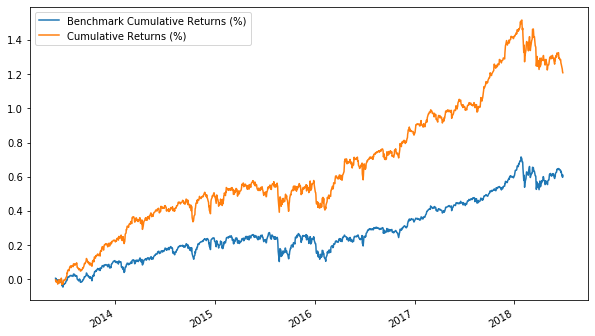

In [23]:
backtest1.analyze_performance()
backtest1.analyze.tail(5)
backtest1.analyze.plot(y={'Cumulative Returns (%)','Benchmark Cumulative Returns (%)'}, figsize=(10,6))

### Sharpe Ratio

Definition: Ratio that shows risk-adjusted return of portfolio

Calculation: (Portfolio Return - Risk Free Rate) / (Portfolio Std. Dev)

In [24]:
#Sharpe Ratio Function (default: assumes 0% risk free rate and annualizes sharpe)
def sharpe(returns, risk_free_rate=0, days=252):
    sharpe_ratio = returns.mean()/returns.std() * np.sqrt(days)
    return sharpe_ratio

### Sortino Ratio

Definition: Ratio that shows risk-adjusted return of portfolio (using only negative volatility) --> Doesn't penalize a stock for increases in price (which would affect standard deviation)

Calculation: (Portfolio Return - Risk Free Rate) / (Portfolio Std. Dev [Negative Values])

Parity Check: Sortino Ratio should be higher than Sharpe Ratio since its only considering the volatility of negative returns

In [25]:
def sortino(returns, risk_free_rate=0, days=252):
    neg_returns = returns[returns < 0]
    sortino_ratio = returns.mean()/neg_returns.std() * np.sqrt(days)
    return sortino_ratio

# Part 3: Optimization of Input Parameters 

# Optimize

### Step 1: Optimize by basket size

In [26]:
optimize = Backtester()

In [27]:
basket = pd.DataFrame()
basket_tracker = 5
while(basket_tracker < 25):
    optimize.simulate(basket_size = basket_tracker)
    optimize.analyze_performance()
    basket[optimize.basket_size] = optimize.analyze['Cumulative Returns (%)']
    basket_tracker += 5

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101872.44734780543 Final Portfolio + Cash Value: 101902.945981316
Performance (%) =  103.74489469561085
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  110349.91327111583 Final Portfolio + Cash Value: 110382.87002824739
Performance (%) =  120.69982654223166
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  106682.03636263755 Final Portfolio + Cash Value: 106713.92699627517
Performance (%) =  113.3640727252751
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  20
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583      76.0
ACN    70.534546      35.0
BIIB  235.240005      10.0
BKNG  801.119995       3.0
C      45.486343      54.0
COF    52.724289      47.0
COST   98.545853      25.0
CSCO   18.742292     133.0
CVX    93.243530      26.0
DUK    49.744247      50.0
EXC    26.340830      94.0
F      10.317766     242.0
FB     24.309999     102.0
GE     18.404270     135.0
GILD   48.009838      52.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101186.35953562877 Final Portfolio + Cash Value: 101216.5344475924
Performance (%) =  102.37271907125754
////////// ----------- //////////


In [28]:
basket['Benchmark'] = optimize.analyze['Benchmark Cumulative Returns (%)']

In [29]:
#Displays the Cumulative Returns for all basket sizes and benchmark
basket.iloc[-1]

5            1.038668
10           1.208314
15           1.134912
20           1.024930
Benchmark    0.608523
Name: 2018-06-28 00:00:00, dtype: float64

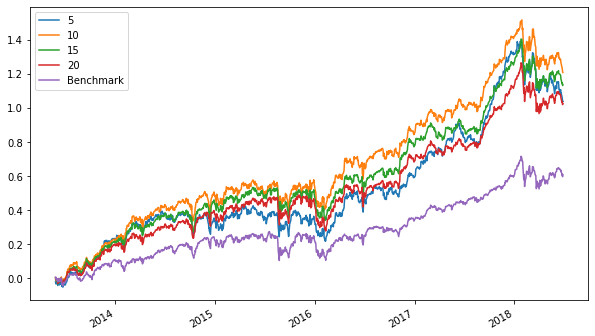

In [30]:
basket.plot(figsize=(10,6))

### Step 2: Check that each year produces returns (make sure one year isnt abnormally affecting total return) 

In [31]:
optimize = Backtester()

In [32]:
sim_start = datetime.datetime.strptime('2013-05-24', '%Y-%m-%d')
sim_end = sim_start + datetime.timedelta(days=364)
optimize.basket_size = 10
years = pd.DataFrame()
years.insert(0,'Index', ['Annual Return', 'Benchmark Annual Return', 'Sharpe','Benchmark Sharpe', 'Sortino', 'Benchmark Sortino'])
years.set_index('Index',inplace = True)

while(sim_end < pd.Timestamp(training_end)): 
    optimize.simulate(sim_start,sim_end)
    optimize.analyze_performance()
    analysis = optimize.analyze
    years[sim_end] = analysis['Cumulative Returns (%)'].iloc[-1]
    years[sim_end].loc['Sharpe'] = sharpe(analysis['Daily Returns (%)'])
    years[sim_end].loc['Sortino'] = sortino(analysis['Daily Returns (%)'])
    years[sim_end].loc['Benchmark Annual Return'] = analysis['Benchmark Cumulative Returns (%)'].iloc[-1]
    years[sim_end].loc['Benchmark Sharpe'] = sharpe(analysis['Benchmark Daily Returns (%)'])
    years[sim_end].loc['Benchmark Sortino'] = sortino(analysis['Benchmark Daily Returns (%)'])
    sim_start = sim_end
    sim_end += datetime.timedelta(days=356)
    

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2014-05-23
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  69467.71672600877 Final Portfolio + Cash Value: 69488.53317527846
Performance (%) =  38.93543345201755
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2014-05-23 until  2015-05-14
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BMY    41.081051     121.0
CMCSA  23.114378     216.0
CSCO   20.133902     248.0
DD     58.512604      85.0
DHR    38.843567     128.0
DIS    76.680748      65.0
DUK    53.035511      94.0
F      11.485541     435.0
GM     25.955523     192.0
HON    76.856651      65.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  56627.34243994076 Final Portfolio + Cash Value: 56644.22203593781
Performance (%) =  13.25468487988152
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2015-05-14 until  2016-05-04
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
            Entry  Quantity
ABT     43.804420     114.0
ADBE    79.430000      62.0
AMGN   140.434067      35.0
BMY     58.315853      85.0
BRK-B  145.779999      34.0
CHTR   176.789993      28.0
CMCSA   25.571249     195.0
DUK     59.341072      84.0
FDX    163.614441      30.0
GILD    93.542175      53.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  50561.50112766339 Final Portfolio + Cash Value: 50576.37303996579
Performance (%) =  1.1230022553267773
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2016-05-04 until  2017-04-25
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
            Entry  Quantity
AAPL    87.889236      56.0
ALL     60.201981      83.0
AMZN   670.900024       7.0
CHTR   212.429993      23.0
CL      65.037239      76.0
FB     118.059998      42.0
GD     129.285248      38.0
GOOG   695.700012       7.0
GOOGL  711.369995       7.0
NFLX    90.790001      55.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  59986.92998983622 Final Portfolio + Cash Value: 60004.85383564692
Performance (%) =  19.973859979672444
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2017-04-25 until  2018-04-16
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
            Entry  Quantity
ALL     76.332359      65.0
CMCSA   36.011585     138.0
DHR     81.781654      61.0
EXC     31.138861     160.0
GD     180.118408      27.0
GE      26.261374     190.0
HON    115.100761      43.0
INTC    33.777348     147.0
JNJ    112.410667      44.0
VZ      40.396355     123.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  59882.99579939616 Final Portfolio + Cash Value: 59900.841723602876
Performance (%) =  19.765991598792315
////////// ----------- //////////


In [33]:
#years will show different performance metrics for each individual year
years

,2014-05-23,2015-05-14,2016-05-04,2017-04-25,2018-04-16
Index,,,,,
Annual Return,0.390184,0.133223,0.011828,0.200451,0.198373
Benchmark Annual Return,0.134924,0.107170,-0.025137,0.160494,0.114108
Sharpe,2.590177,1.003030,0.156793,1.650253,1.505573
Benchmark Sharpe,1.220030,0.940555,-0.069741,1.672225,0.956650
Sortino,3.960507,1.478068,0.226614,2.396497,1.536250
Benchmark Sortino,1.719448,1.367978,-0.099754,2.243504,0.969907


### Step 3: Optimize for different rebalance periods

In [34]:
optimize = Backtester()

In [35]:
rebalance_dur = [1, 3, 5, 10, 15, 20, 30]
rebalance = pd.DataFrame()
rebalance.insert(0,'Index', ['Net Return', 'Sharpe', 'Sortino'])
rebalance.set_index('Index',inplace = True)
rebalance_detailed = pd.DataFrame()

for duration in rebalance_dur:
    optimize.simulate(rebalance_duration = duration)
    optimize.analyze_performance()
    analysis = optimize.analyze
    rebalance[duration] = analysis['Cumulative Returns (%)'].iloc[-1]
    rebalance_detailed[duration] = analysis['Cumulative Returns (%)']
    rebalance[duration].loc['Sharpe'] = sharpe(analysis['Daily Returns (%)'])
    rebalance[duration].loc['Sortino'] = sortino(analysis['Daily Returns (%)'])

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  104342.0660052382 Final Portfolio + Cash Value: 104373.31703941026
Performance (%) =  108.6841320104764
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 3
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  107627.55473916313 Final Portfolio + Cash Value: 107659.50229598228
Performance (%) =  115.25510947832625
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  110349.91327111583 Final Portfolio + Cash Value: 110382.87002824739
Performance (%) =  120.69982654223166
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  102715.92087046753 Final Portfolio + Cash Value: 102746.6510534822
Performance (%) =  105.43184174093506
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  100031.47195821452 Final Portfolio + Cash Value: 100061.40309692093
Performance (%) =  100.06294391642905
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 20
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  82994.8379644798 Final Portfolio + Cash Value: 83019.59189185406
Performance (%) =  65.98967592895958
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 30
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  92119.8944664115 Final Portfolio + Cash Value: 92146.73902202558
Performance (%) =  84.23978893282299
////////// ----------- //////////


In [36]:
#rebalance holds the  return for each of the different rebalance periods
rebalance

,1,3,5,10,15,20,30
Index,,,,,,,
Net Return,1.088087,1.153831,1.208314,1.055544,1.001823,0.660886,0.843483
Sharpe,1.091054,1.139717,1.186329,1.080543,1.060254,0.784116,0.927632
Sortino,1.446058,1.538442,1.602689,1.435723,1.418195,1.042712,1.243253


In [37]:
rebalance_detailed['Benchmark'] = optimize.analyze['Benchmark Cumulative Returns (%)']

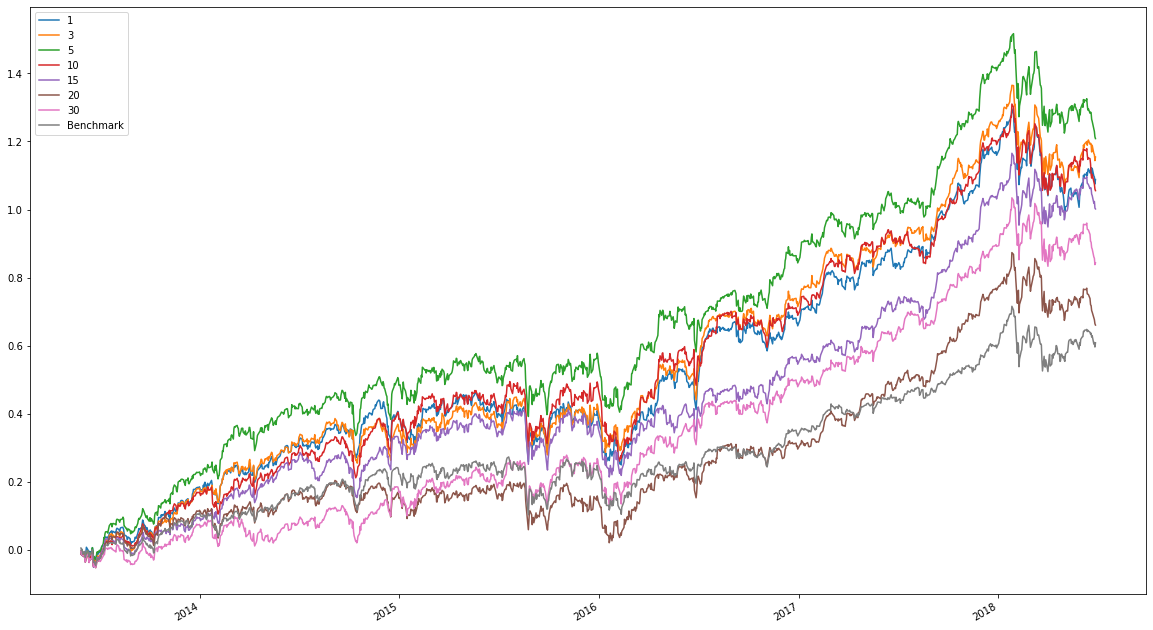

In [38]:
#rebalance_detailed shows the daily cumulative returns for all different rebalance periods compared to the benchmark
rebalance_detailed.plot(figsize=(20,12))

### Step 4: Optimize for Weightage of Stocks

In [39]:
optimize = Backtester()

In [40]:
weightage = [(1/3,1/3,1/3),(1/2,1/4,1/4),(1/4,1/2,1/4),(1/4,1/4,1/2),(1/6,1/6,2/3),(1/6,2/3,1/6),(1/6,1/6,2/3)]
indicator_weight = pd.DataFrame()
indicator_weight.insert(0,'Index', ['Net Return', 'Sharpe', 'Sortino'])
indicator_weight.set_index('Index',inplace = True)
indicator_weight_detailed = pd.DataFrame()

for combination in weightage:
    optimize.simulate(weights = combination)
    optimize.analyze_performance()
    analysis = optimize.analyze
    indicator_weight[combination] = analysis['Cumulative Returns (%)'].iloc[-1]
    indicator_weight_detailed[combination] = analysis['Cumulative Returns (%)']
    indicator_weight[combination].loc['Sharpe'] = sharpe(analysis['Daily Returns (%)'])
    indicator_weight[combination].loc['Sortino'] = sortino(analysis['Daily Returns (%)'])

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  110349.91327111583 Final Portfolio + Cash Value: 110382.87002824739
Performance (%) =  120.69982654223166
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  111270.13103546466 Final Portfolio + Cash Value: 111303.45810376186
Performance (%) =  122.54026207092932
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103395.48189110972 Final Portfolio + Cash Value: 103426.40004749782
Performance (%) =  106.79096378221944
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  113226.60928585584 Final Portfolio + Cash Value: 113260.46052033192
Performance (%) =  126.45321857171167
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  112806.8094994286 Final Portfolio + Cash Value: 112840.52182666972
Performance (%) =  125.61361899885719
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  107145.66471007114 Final Portfolio + Cash Value: 107177.65612592807
Performance (%) =  114.29132942014229
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  112806.8094994286 Final Portfolio + Cash Value: 112840.52182666972
Performance (%) =  125.61361899885719
////////// ----------- //////////


In [41]:
#indicator_weight holds the returns for different combinations of weights for EMA, SMA, and MACD
indicator_weight

,"(0.3333333333333333, 0.3333333333333333, 0.3333333333333333)","(0.5, 0.25, 0.25)","(0.25, 0.5, 0.25)","(0.25, 0.25, 0.5)","(0.16666666666666666, 0.16666666666666666, 0.6666666666666666)","(0.16666666666666666, 0.6666666666666666, 0.16666666666666666)"
Index,,,,,,
Net Return,1.208314,1.226731,1.069146,1.265886,1.257484,1.144191
Sharpe,1.186329,1.195796,1.094926,1.226921,1.218416,1.137192
Sortino,1.602689,1.613999,1.478749,1.667338,1.652690,1.544205


In [42]:
indicator_weight_detailed['Benchmark'] = analysis['Benchmark Cumulative Returns (%)']

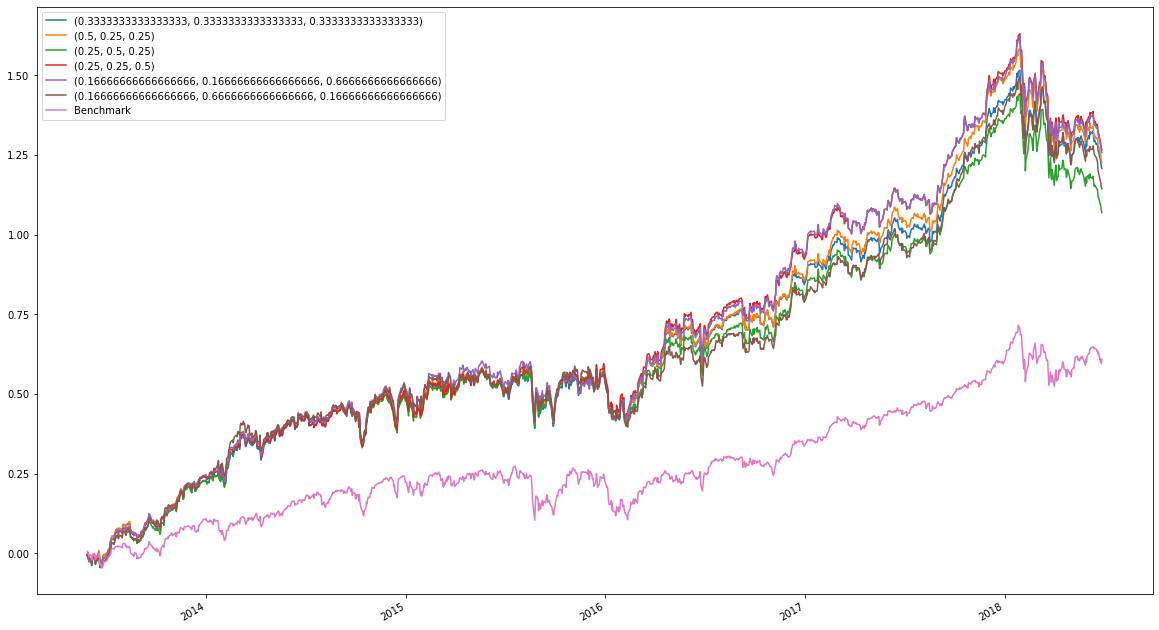

In [43]:
indicator_weight_detailed.plot(figsize=(20,12))

### Step 5: Try optimizing all variables in one go (eyeballing)

In [44]:
optimize = Backtester()

In [45]:
optimize.simulate(basket_size = 10, rebalance_duration= 5, weights= (1/6,2/6,3/6))
optimize.analyze_performance()

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.3333333333333333 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  113553.38200518857 Final Portfolio + Cash Value: 113587.38291957225
Performance (%) =  127.10676401037715
////////// ----------- //////////


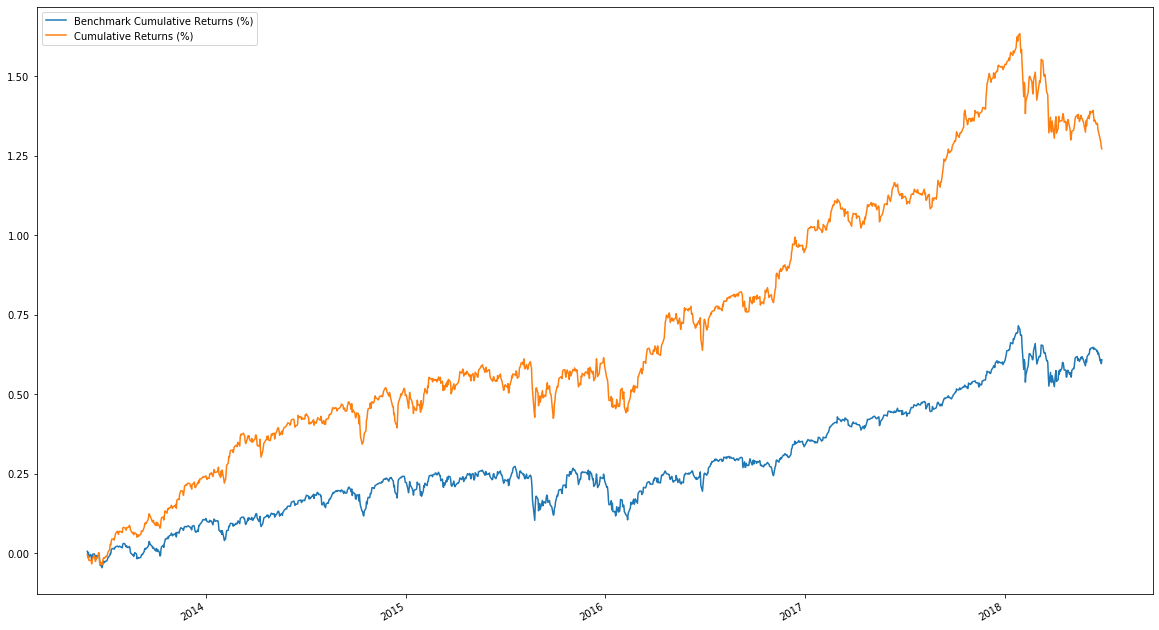

In [46]:
optimize.analyze.plot(y={'Cumulative Returns (%)','Benchmark Cumulative Returns (%)'}, figsize=(20,12))

### Step 6: Optimize across all variables using for loops

#### WARNING! This is not efficient as it uses multiple nested for loops. Takes a long time to run!

In [47]:
best_basket = 0
best_rebalance = 0
best_weight = [0,0,0]
best_return = 0

In [48]:
weightage = [(1/3,1/3,1/3),(1/2,1/4,1/4),(1/4,1/2,1/4),(1/4,1/4,1/2),(1/6,1/6,2/3),(1/6,2/3,1/6),(1/6,1/6,2/3)]

for baskets in (5, 10, 15):
    for rebalances in (1, 5, 10, 15):
        for weight in weightage:
            optimize.simulate(basket_size= baskets, rebalance_duration= rebalances, weights= weight)
            optimize.analyze_performance()
            if (best_return < optimize.analyze['Cumulative Returns (%)'].iloc[-1]):
                best_basket = baskets
                best_rebalance = rebalances
                best_weight = weight
                best_return = optimize.analyze['Cumulative Returns (%)'].iloc[-1]
            

////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  118929.26798041603 Final Portfolio + Cash Value: 118964.92435627509
Performance (%) =  137.85853596083206
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  117945.35275215498 Final Portfolio + Cash Value: 117980.68015303847
Performance (%) =  135.89070550430998
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  122833.61892610308 Final Portfolio + Cash Value: 122870.4123463057
Performance (%) =  145.66723785220617
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  118073.03127473714 Final Portfolio + Cash Value: 118108.38023479267
Performance (%) =  136.14606254947427
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  117012.9388963753 Final Portfolio + Cash Value: 117047.97695976261
Performance (%) =  134.02587779275058
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      42.0
DUK    49.744247     200.0
EXC    26.340830     379.0
IBM   154.403519      64.0
T      24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  118209.09398610076 Final Portfolio + Cash Value: 118244.52726758421
Performance (%) =  136.41818797220154
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  117012.9388963753 Final Portfolio + Cash Value: 117047.97695976261
Performance (%) =  134.02587779275058
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101872.44734780543 Final Portfolio + Cash Value: 101902.945981316
Performance (%) =  103.74489469561085
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  106279.20451732863 Final Portfolio + Cash Value: 106311.03594395255
Performance (%) =  112.55840903465726
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  112972.36776934944 Final Portfolio + Cash Value: 113006.21052414032
Performance (%) =  125.94473553869886
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  104580.20234175856 Final Portfolio + Cash Value: 104611.55168238204
Performance (%) =  109.16040468351711
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  108936.13837524972 Final Portfolio + Cash Value: 108968.76430076544
Performance (%) =  117.87227675049945
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      42.0
DUK    49.744247     200.0
EXC    26.340830     379.0
IBM   154.403519      64.0
T      24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  111481.49071376497 Final Portfolio + Cash Value: 111514.86494942209
Performance (%) =  122.96298142752995
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  108936.13837524972 Final Portfolio + Cash Value: 108968.76430076544
Performance (%) =  117.87227675049945
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  98630.95643175117 Final Portfolio + Cash Value: 98660.48500391495
Performance (%) =  97.26191286350235
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  102253.77537850698 Final Portfolio + Cash Value: 102284.41238948377
Performance (%) =  104.50755075701397
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  111314.5659265183 Final Portfolio + Cash Value: 111347.88729199111
Performance (%) =  122.62913185303661
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  94867.10580220203 Final Portfolio + Cash Value: 94895.4877471403
Performance (%) =  89.73421160440405
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  95576.80440877477 Final Portfolio + Cash Value: 95605.44445963498
Performance (%) =  91.15360881754954
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      42.0
DUK    49.744247     200.0
EXC    26.340830     379.0
IBM   154.403519      64.0
T      24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103918.76699674051 Final Portfolio + Cash Value: 103949.88185075892
Performance (%) =  107.83753399348102
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  95576.80440877477 Final Portfolio + Cash Value: 95605.44445963498
Performance (%) =  91.15360881754954
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  106153.05799060166 Final Portfolio + Cash Value: 106184.86994415753
Performance (%) =  112.30611598120332
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  107604.03207919146 Final Portfolio + Cash Value: 107636.27619885832
Performance (%) =  115.20806415838291
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  112407.52782383935 Final Portfolio + Cash Value: 112441.24387257439
Performance (%) =  124.81505564767869
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  104864.29575939762 Final Portfolio + Cash Value: 104895.72532561084
Performance (%) =  109.72859151879524
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  107010.09277029609 Final Portfolio + Cash Value: 107042.16732121486
Performance (%) =  114.0201855405922
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      42.0
DUK    49.744247     200.0
EXC    26.340830     379.0
IBM   154.403519      64.0
T      24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  100164.23210993403 Final Portfolio + Cash Value: 100194.2481377096
Performance (%) =  100.32846421986807
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  5
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
DUK   49.744247     200.0
EXC   26.340830     379.0
FB    24.309999     411.0
IBM  154.403519      64.0
T     24.662882     405.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  107010.09277029609 Final Portfolio + Cash Value: 107042.16732121486
Performance (%) =  114.0201855405922
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  104342.0660052382 Final Portfolio + Cash Value: 104373.31703941026
Performance (%) =  108.6841320104764
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  108634.08912773016 Final Portfolio + Cash Value: 108666.6199727924
Performance (%) =  117.26817825546033
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  104599.53281020449 Final Portfolio + Cash Value: 104630.87155096223
Performance (%) =  109.19906562040897
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  110952.24259597089 Final Portfolio + Cash Value: 110985.52276112363
Performance (%) =  121.90448519194179
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103385.29286122877 Final Portfolio + Cash Value: 103416.27228229199
Performance (%) =  106.77058572245753
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101243.01810250364 Final Portfolio + Cash Value: 101273.37611282698
Performance (%) =  102.4860362050073
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103385.29286122877 Final Portfolio + Cash Value: 103416.27228229199
Performance (%) =  106.77058572245753
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  110349.91327111583 Final Portfolio + Cash Value: 110382.87002824739
Performance (%) =  120.69982654223166
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  111270.13103546466 Final Portfolio + Cash Value: 111303.45810376186
Performance (%) =  122.54026207092932
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103395.48189110972 Final Portfolio + Cash Value: 103426.40004749782
Performance (%) =  106.79096378221944
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  113226.60928585584 Final Portfolio + Cash Value: 113260.46052033192
Performance (%) =  126.45321857171167
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  112806.8094994286 Final Portfolio + Cash Value: 112840.52182666972
Performance (%) =  125.61361899885719
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  107145.66471007114 Final Portfolio + Cash Value: 107177.65612592807
Performance (%) =  114.29132942014229
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  112806.8094994286 Final Portfolio + Cash Value: 112840.52182666972
Performance (%) =  125.61361899885719
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  102715.92087046753 Final Portfolio + Cash Value: 102746.6510534822
Performance (%) =  105.43184174093506
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  105355.0365054793 Final Portfolio + Cash Value: 105386.55353472162
Performance (%) =  110.71007301095858
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  95004.24892414032 Final Portfolio + Cash Value: 95032.61670009473
Performance (%) =  90.00849784828064
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101198.5307790925 Final Portfolio + Cash Value: 101228.75777593201
Performance (%) =  102.397061558185
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103518.73065065147 Final Portfolio + Cash Value: 103549.63309747154
Performance (%) =  107.03746130130294
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  100381.14254210319 Final Portfolio + Cash Value: 100411.14175950698
Performance (%) =  100.76228508420637
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103518.73065065147 Final Portfolio + Cash Value: 103549.63309747154
Performance (%) =  107.03746130130294
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  100031.47195821452 Final Portfolio + Cash Value: 100061.40309692093
Performance (%) =  100.06294391642905
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  98976.9243187788 Final Portfolio + Cash Value: 99006.5238313055
Performance (%) =  97.95384863755758
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  91698.65590297629 Final Portfolio + Cash Value: 91725.95671040444
Performance (%) =  83.39731180595258
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
BIIB  235.240005      21.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  97236.13940639996 Final Portfolio + Cash Value: 97265.2374526211
Performance (%) =  94.47227881279993
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  96278.17044805379 Final Portfolio + Cash Value: 96306.97684206587
Performance (%) =  92.55634089610759
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
BIIB  235.240005      21.0
BKNG  801.119995       6.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
GILD   48.009838     104.0
IBM   154.403519      32.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  93262.14904473035 Final Portfolio + Cash Value: 93289.76869369352
Performance (%) =  86.5242980894607
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     153.0
COST   98.545853      50.0
CSCO   18.742292     266.0
DUK    49.744247     100.0
EXC    26.340830     189.0
FB     24.309999     205.0
GE     18.404270     271.0
IBM   154.403519      32.0
PFE    22.383799     223.0
T      24.662882     202.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  96278.17044805379 Final Portfolio + Cash Value: 96306.97684206587
Performance (%) =  92.55634089610759
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  103459.13711759701 Final Portfolio + Cash Value: 103490.14493143596
Performance (%) =  106.91827423519402
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101614.63586275581 Final Portfolio + Cash Value: 101645.0968088545
Performance (%) =  103.22927172551162
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
C      45.486343      73.0
COST   98.545853      33.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  108306.3811043784 Final Portfolio + Cash Value: 108338.80008939312
Performance (%) =  116.61276220875678
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  106018.79436714578 Final Portfolio + Cash Value: 106050.57060325227
Performance (%) =  112.03758873429155
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  108381.53645750649 Final Portfolio + Cash Value: 108414.0035911914
Performance (%) =  116.76307291501298
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABBV   33.521160      99.0
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
BLK   234.120956      14.0
C      45.486343      73.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
GM     25.145714     132.0
IBM   154.403519      21.0
T      24.662882     135.

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101531.95042308742 Final Portfolio + Cash Value: 101562.3270477582
Performance (%) =  103.06390084617483
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 1
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  108381.53645750649 Final Portfolio + Cash Value: 108414.0035911914
Performance (%) =  116.76307291501298
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  106682.03636263755 Final Portfolio + Cash Value: 106713.92699627517
Performance (%) =  113.3640727252751
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  105349.8131355498 Final Portfolio + Cash Value: 105381.21426705616
Performance (%) =  110.69962627109962
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
C      45.486343      73.0
COST   98.545853      33.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  101285.23585142657 Final Portfolio + Cash Value: 101315.50989420076
Performance (%) =  102.57047170285314
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  105239.18340204535 Final Portfolio + Cash Value: 105270.65536451197
Performance (%) =  110.47836680409071
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  105157.49114620843 Final Portfolio + Cash Value: 105188.94091525483
Performance (%) =  110.31498229241686
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABBV   33.521160      99.0
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
BLK   234.120956      14.0
C      45.486343      73.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
GM     25.145714     132.0
IBM   154.403519      21.0
T      24.662882     135

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  99207.97304535453 Final Portfolio + Cash Value: 99237.08276455048
Performance (%) =  98.41594609070907
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  105157.49114620843 Final Portfolio + Cash Value: 105188.94091525483
Performance (%) =  110.31498229241686
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  90949.02811422622 Final Portfolio + Cash Value: 90976.04732297978
Performance (%) =  81.89805622845245
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  90608.13988918449 Final Portfolio + Cash Value: 90635.09927303667
Performance (%) =  81.21627977836897
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
C      45.486343      73.0
COST   98.545853      33.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  87070.85642821118 Final Portfolio + Cash Value: 87096.69393681141
Performance (%) =  74.14171285642234
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  93471.95459575245 Final Portfolio + Cash Value: 93499.83776129427
Performance (%) =  86.94390919150491
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  93849.10505782194 Final Portfolio + Cash Value: 93877.05917282877
Performance (%) =  87.69821011564389
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABBV   33.521160      99.0
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
BLK   234.120956      14.0
C      45.486343      73.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
GM     25.145714     132.0
IBM   154.403519      21.0
T      24.662882     135.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  90046.19750359943 Final Portfolio + Cash Value: 90072.75080052667
Performance (%) =  80.09239500719885
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 10
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  93849.10505782194 Final Portfolio + Cash Value: 93877.05917282877
Performance (%) =  87.69821011564389
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.3333333333333333 0.3333333333333333 0.3333333333333333
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  94874.97674873564 Final Portfolio + Cash Value: 94902.89355999949
Performance (%) =  89.7499534974713
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.5 0.25 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  91795.97624079467 Final Portfolio + Cash Value: 91822.98942582236
Performance (%) =  83.59195248158933
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.25 0.5 0.25
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
C      45.486343      73.0
COST   98.545853      33.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  85254.47910837564 Final Portfolio + Cash Value: 85279.76548068838
Performance (%) =  70.50895821675128
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.25 0.25 0.5
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
F      10.317766     322.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  94099.25995861167 Final Portfolio + Cash Value: 94126.93588909644
Performance (%) =  88.19851991722334
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  97652.68650410196 Final Portfolio + Cash Value: 97681.26852591518
Performance (%) =  95.30537300820393
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.6666666666666666 0.16666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABBV   33.521160      99.0
ABT    32.626583     102.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
BLK   234.120956      14.0
C      45.486343      73.0
CSCO   18.742292     177.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
GILD   48.009838      69.0
GM     25.145714     132.0
IBM   154.403519      21.0
T      24.662882     135.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  88200.40134376721 Final Portfolio + Cash Value: 88226.42541527885
Performance (%) =  76.40080268753442
////////// ----------- //////////
////////// ----------- //////////
Simulation is running from  2013-05-24 until  2018-06-28
Universe Size is:  98
Basket Size is:  15
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 15
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.16666666666666666 0.6666666666666666
Transaction Costs: 0.0003
Initial Portfolio:
           Entry  Quantity
ABT    32.626583     102.0
AMZN  261.739990      12.0
BIIB  235.240005      14.0
BKNG  801.119995       4.0
COST   98.545853      33.0
CSCO   18.742292     177.0
CVX    93.243530      35.0
DUK    49.744247      66.0
EXC    26.340830     126.0
FB     24.309999     137.0
GE     18.404270     181.0
IBM   154.403519      21.0
PFE    22.383799     148.0
T      24.662882     135.0
XOM    68.638519      48.0

/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  97652.68650410196 Final Portfolio + Cash Value: 97681.26852591518
Performance (%) =  95.30537300820393
////////// ----------- //////////


In [49]:
print(best_return, best_basket, best_rebalance, best_weight)

1.4581426474166879 5 1 (0.25, 0.5, 0.25)


Note: Previously there was an attempt to optimize simulation using scipy or pulp. However, these approaches did not work well and have been omitted from this version.

# Part 4: Out of Sample Testing 

# Testing 

After optimizing and processing the data, it is important to test it using out-of-sample data sets to make sure that the model works, and that we didn't overfit the data. We want this method of generating returns to be valid across any time period, so that we are confident it can be applied to future data.

### Step 1: Future Data Test (June 2018 - June 2020)

In [50]:
test = Backtester()

#Start and End Dates are outside of the training dataset
test_start = '2018-06-28'
test_end = '2020-06-15'

In [51]:
test.simulate(sim_start = pd.Timestamp(test_start), sim_end= pd.Timestamp(test_end), 
              basket_size = 10, rebalance_duration= 5, weights= (1/6,2/6,3/6))
test.analyze_performance()

////////// ----------- //////////
Simulation is running from  2018-06-28 until  2020-06-15
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.3333333333333333 0.5
Transaction Costs: 0.0003
Initial Portfolio:
            Entry  Quantity
BA     322.092133      15.0
BKNG  2019.489990       2.0
BLK    473.291321      10.0
CL      61.386063      81.0
DHR     97.607010      51.0
DUK     71.863907      69.0
EMR     64.122101      77.0
FDX    219.685364      22.0
HON    130.626175      38.0
UPS     98.038277      50.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  60299.07667748315 Final Portfolio + Cash Value: 60317.077766901755
Performance (%) =  20.5981533549663
////////// ----------- //////////


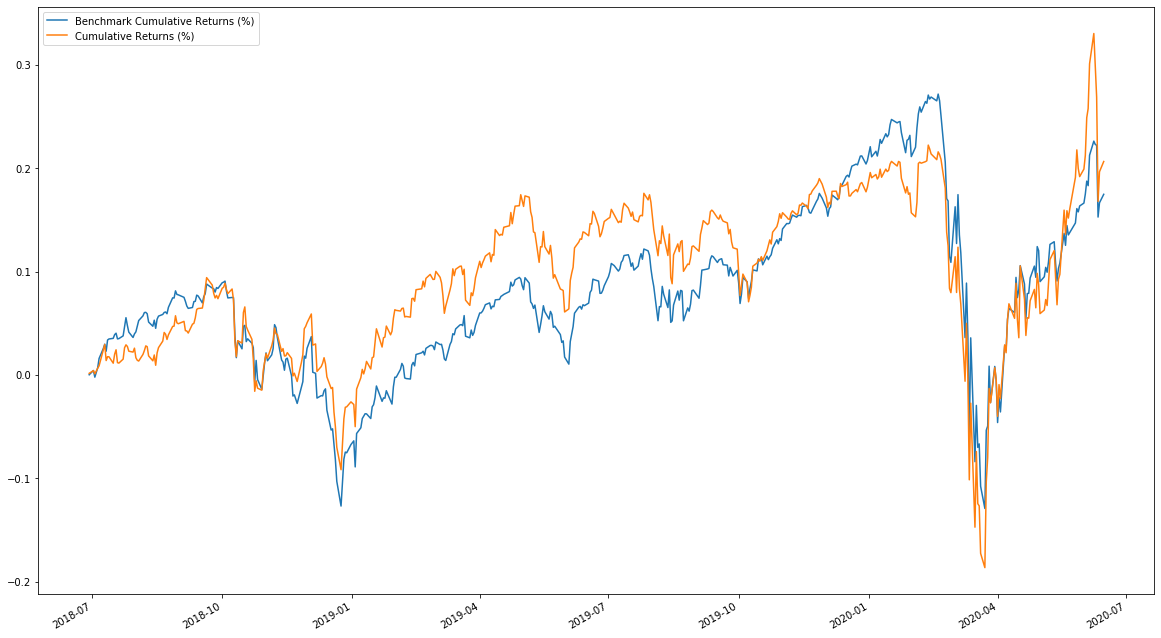

In [52]:
test.analyze.plot(y={'Cumulative Returns (%)','Benchmark Cumulative Returns (%)'}, figsize=(20,12))

**Metrics for Strategy**

In [53]:
print('Return: ', test.analyze['Cumulative Returns (%)'].iloc[-1])
print('Sharpe: ', sharpe(test.analyze['Daily Returns (%)']))
print('Sortino: ', sortino(test.analyze['Daily Returns (%)']))

Return:  0.20669015582721406
Sharpe:  0.4790563876326162
Sortino:  0.5704965959577769


**Metrics for Benchmark**

In [54]:
print('Return: ', test.analyze['Benchmark Cumulative Returns (%)'].iloc[-1])
print('Sharpe: ', sharpe(test.analyze['Benchmark Daily Returns (%)']))
print('Sortino: ', sortino(test.analyze['Benchmark Daily Returns (%)']))

Return:  0.1749288502390769
Sharpe:  0.44836092107927045
Sortino:  0.4949031944418458


### Step 2: Past Data Test (Jan 2010- Jan 2013)

Note: Since this data set is from before the training period, we must remove a few stock that did not exist during this time from our list of the SP100. Look at the commented out code in the first few cells to see that ABBV, FB, KMI, and GM have to be removed for this backtest to work.

In [324]:
test = Backtester()
test_start = '2010-01-04'
test_end = '2012-12-28'

In [325]:
test.simulate(sim_start = pd.Timestamp(test_start), sim_end= pd.Timestamp(test_end), basket_size = 10, rebalance_duration= 5, weights= (1/6,2/6,3/6))
test.analyze_performance()

////////// ----------- //////////
Simulation is running from  2010-01-04 until  2012-12-28
Universe Size is:  98
Basket Size is:  10
Starting Capital:  50000
Current Balance:  50000
Rebalance Duration is: 5
Indicator Weights (EMA, SMA, MACD):  0.16666666666666666 0.3333333333333333 0.5
Transaction Costs: 0.0003
Initial Portfolio:
          Entry  Quantity
COF   33.047562     151.0
COST  45.815430     109.0
CRM   18.705000     267.0
CSCO  18.785395     266.0
CVS   26.591206     187.0
CVX   53.047504      94.0
DD    30.727852     162.0
DHR   18.391703     271.0
DIS   27.933924     178.0
XOM   48.404034     103.0


/Users/jaiveerkhanna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


Simulation has completed, here are some performance metrics:
Final Cash Balance =  67665.37732452578 Final Portfolio + Cash Value: 67685.63390696366
Performance (%) =  35.330754649051556
////////// ----------- //////////


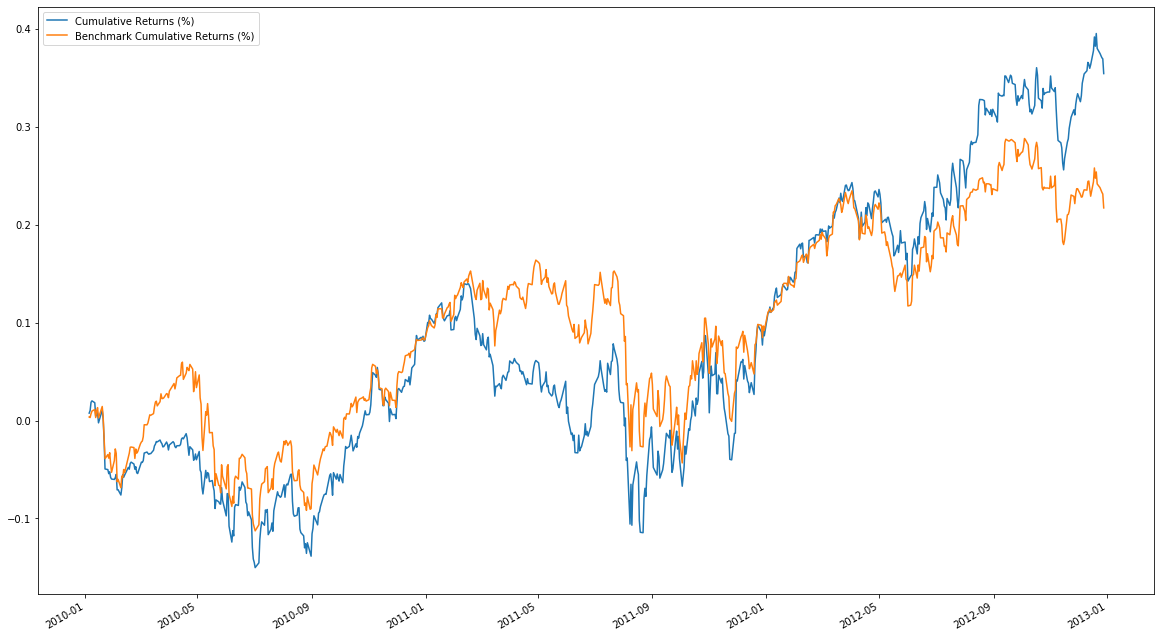

In [326]:
test.analyze.plot(y={'Cumulative Returns (%)','Benchmark Cumulative Returns (%)'}, figsize=(20,12))

**Metrics for Strategy**

In [327]:
print('Return: ', test.analyze['Cumulative Returns (%)'].iloc[-1])
print('Sharpe: ', sharpe(test.analyze['Daily Returns (%)']))
print('Sortino: ', sortino(test.analyze['Daily Returns (%)']))

Return:  0.3541177284838506
Sharpe:  0.6376540789857855
Sortino:  0.8632473637229557


**Metrics for Benchmark**

In [328]:
print('Return: ', test.analyze['Benchmark Cumulative Returns (%)'].iloc[-1])
print('Sharpe: ', sharpe(test.analyze['Benchmark Daily Returns (%)']))
print('Sortino: ', sortino(test.analyze['Benchmark Daily Returns (%)']))

Return:  0.21701453270324933
Sharpe:  0.45958147539397604
Sortino:  0.5955055896505499


# Conclusion 

Overall, I am extremely satisfied with the results of my strategy. Not only did it outperform the benchmark in raw returns, it also outperformed in terms of risk-adjusted returns (healthier Sharpe and Sortino ratios). 

During my optimization period, I was glad to see that the strategy consistently outperformed the benchmark, even when calculated on a year by year basis. This improves my confidence in the strategy's power, and it is a good sign to see that each individual year was succesful. 

Furthermore, I am inclined to believe the strategy is not overfitted to its training data, as it outperformed the benchmark during both test periods (beating the benchmark by 3% and 15% during the future and historical test period resepectively). 

I am looking forward to seeing if it stands the test of time.

**Disclaimer: Past performance is not indicative of future returns**